FCPG Tools (v2) Test Notebooks
===============================

In [1]:
# import non-fcpgtools dependencies
import xarray as xr
import geopandas as gpd
import numpy as np
import pydaymet
from pathlib import Path
from importlib import reload

In [2]:
# import fcpgtools using conda-develop
!conda-develop C:\\Users\\xrnogueira\\Documents\\FCPGtools\\src
import fcpgtools
from fcpgtools import tools, utilities, terrainengine
print(f'fcpgtools directory: {dir(fcpgtools)}')

path exists, skipping C:\Users\xrnogueira\Documents\FCPGtools\src
completed operation for: C:\Users\xrnogueira\Documents\FCPGtools\src
fcpgtools directory: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'terrainengine', 'tools', 'types', 'utilities']


In [3]:
# get all necessary paths for in/out data
examples_dir = str(Path.cwd())
if 'FCPGtools' in examples_dir:
    examples_dir = Path(examples_dir.split('FCPGtools', 2)[0] + 'FCPGtools\\examples')
    print(f'var:examples_dir = {examples_dir}')
else:
    del examples_dir
    print('ERROR: Cant find /FCPGtools/examples!')

var:examples_dir = C:\Users\xrnogueira\Documents\FCPGtools\examples


In [4]:
# get all necessary paths for in/out data
in_data_dir = examples_dir / Path('in_data')
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = examples_dir / Path('out_data')
print(f'Variable in_data_dir accesses {out_data_dir}')

Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (ESRI format).
* `ds_fdr`: downstream basin Flow Direction Raster (ESRI format).
* `daymet_single`: a annual averaged DAYMET precipitation raster.
* `landcover`: a NALCMS 2015 land cover categorical raster.
* `basins_shp`: a shapefile where each row corresponds to a HUC12 level basin.

**Remote files:**
* `daymet_multi`: a 2021 monthly averaged DAYMET precipitation raster accessed via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [5]:
# get tif data paths
us_fdr_tif = in_data_dir / Path('validation_upstream_fdr.tif')
ds_fdr_tif = in_data_dir / Path('validation_downstream_fdr.tif')
landcover_tif = in_data_dir / Path('NALCMS_2015.tif')
daymet_tif = in_data_dir / Path('validation_daymet_an_P_2017.tif')

# get upstream basin shapefile path
us_basin_shp_path = in_data_dir / Path('upstream_wbd.shp')

In [6]:
us_fdr = utilities.intake_raster(us_fdr_tif)
ds_fdr = utilities.intake_raster(ds_fdr_tif)
landcover = utilities.intake_raster(landcover_tif)
daymet_single = utilities.intake_raster(daymet_tif)

### Get the upstrean basin shapefile as a `geopandas.GeoDataFrame`

In [7]:
us_basin_shp = utilities.intake_shapefile(us_basin_shp_path)
us_basin_shp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-111.45208 36.90750, -111.45209 36.9..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-111.69386 37.00586, -111.69386 37.0..."


## Import a 12 month DAYMET precipitation raster from `pydaymet` using our AOI
**Note:** Here we use [`pydaymet`](https://hyriver.readthedocs.io/en/latest/autoapi/pydaymet/pydaymet/index.html) to read Daymet data directly into a `xr.DataSet`. We then query only for precipitation (`variable='prcp')` to get a `xr.DataArray`.

In [8]:
bounding_box = list(us_basin_shp.geometry.total_bounds)
print(f'Boudning box: {bounding_box}')

Boudning box: [-111.71574357557677, 36.771840865839465, -111.43463711872147, 37.00637998943375]


In [9]:
%%time
daymet_multi = pydaymet.get_bygeom(bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_multi.head()

CPU times: total: 1.5 s
Wall time: 1.51 s


<xarray.DataArray 'prcp' (time: 5, y: 5, x: 5)>
dask.array<getitem, shape=(5, 5, 5), dtype=float32, chunksize=(5, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -513.0 -514.0 -515.0 -516.0 -517.0
  * x                        (x) float32 -1e+03 -999.2 -998.2 -997.2 -996.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

# Convert ESRI FDR to TauDEM FDR

In [10]:
# display the dicts sotring D8 formats
print('D8 Formats supported by FCPGtools:')
display(fcpgtools.types.D8ConversionDicts)

D8 Formats supported by FCPGtools:


{'taudem': {'southeast': 8,
  'south': 7,
  'southwest': 6,
  'west': 5,
  'northwest': 4,
  'north': 3,
  'northeast': 2,
  'east': 1,
  'nodata': 0},
 'esri': {'southeast': 2,
  'south': 4,
  'southwest': 8,
  'west': 16,
  'northwest': 32,
  'north': 64,
  'northeast': 128,
  'east': 1,
  'nodata': 255}}

In [11]:
%%time
# make a taudem FDR
us_fdr_taudem = tools.convert_fdr_formats(
        us_fdr,
        out_format='taudem',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 422 ms
Wall time: 425 ms


TauDEM format ustream basin FDR


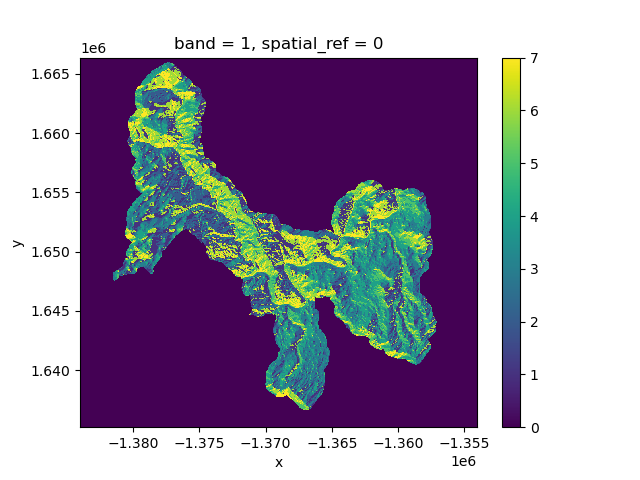

In [12]:
%matplotlib widget
print('TauDEM format ustream basin FDR')
us_fdr_taudem.plot()

In [13]:
print(f'TauDEM nodata value: {us_fdr_taudem.rio.nodata}')

TauDEM nodata value: 0


In [14]:
%%time
# test back-conversion by re-making the esri format FDR
us_fdr_esri = tools.convert_fdr_formats(
        us_fdr_taudem,
        out_format='esri',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from taudem format to esri
CPU times: total: 438 ms
Wall time: 431 ms


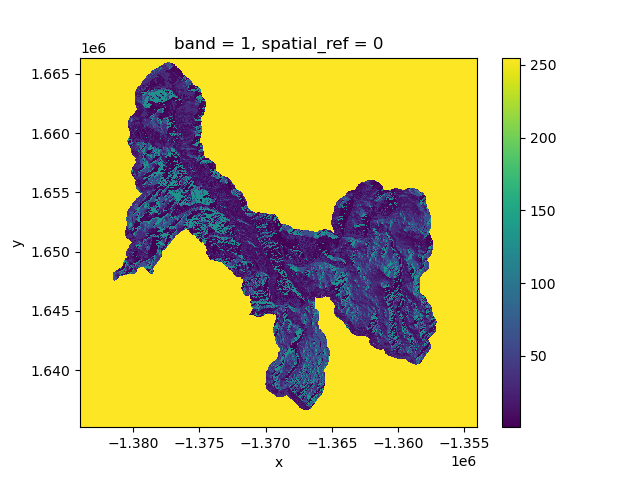

In [15]:
%matplotlib widget
us_fdr_esri.plot()

In [16]:
print(f'ESRI nodata value: {us_fdr_esri.rio.nodata}')

ESRI nodata value: 255


# Prep Parameter Grids

## Resample/reproject/clip Daymet data

Aligning single band daymet data to us_fdr:


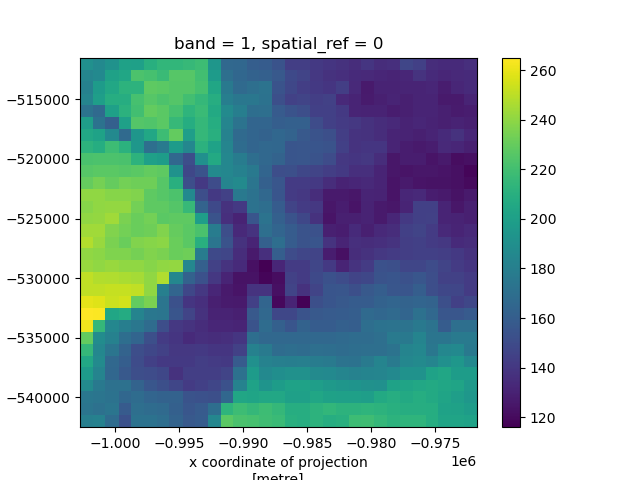

In [17]:
%matplotlib widget
print('Aligning single band daymet data to us_fdr:')
aligned_daymet_single = tools.align_raster(
    daymet_single,
    us_fdr,
    )
aligned_daymet_single.plot()

Aligning multi-band daymet data to us_fdr (plotting january):


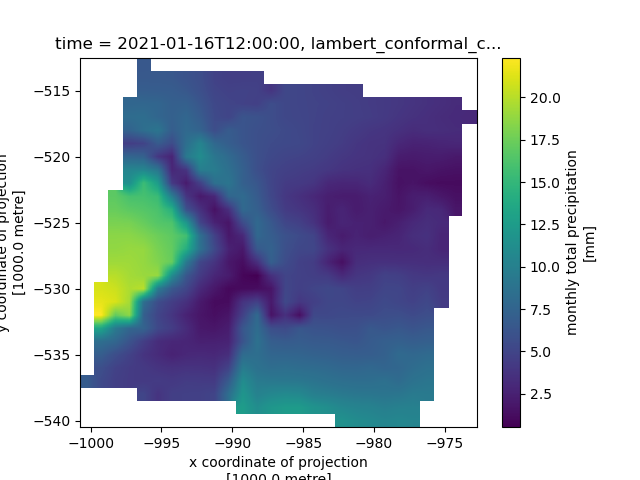

In [18]:
%matplotlib widget
print('Aligning multi-band daymet data to us_fdr (plotting january):')
aligned_daymet_multi = tools.align_raster(
    daymet_multi,
    us_fdr,
    resample_method='bilinear',
    )
aligned_daymet_multi.isel(time=0).plot()

## Align and Binarize Land Cover

In [19]:
# make a dictionary to improve land cover class labeling
landcover_classes = {
    1: 'evergreen forest',
    7: 'tropical shrubland',
    8: 'temperate shrubland',
    9: 'tropical grassland',
    10: 'temperate grassland',
    14: 'wetland',
    15: 'cropland',
    16: 'barren',
    17: 'urban',
    18: 'open water',
    }

In [20]:
np.unique(landcover.values)

array([ 1,  7,  8,  9, 10, 14, 15, 16, 17, 18], dtype=uint8)

In [21]:
aligned_landcover = tools.align_raster(
    landcover,
    us_fdr,
    resample_method='nearest',
    )

In [22]:
binary_landcover = tools.binarize_categorical_raster(
    cat_raster=aligned_landcover,
    categories_dict=landcover_classes,
    ignore_categories=None,
    )
print(f'binary_landcover band labels: {binary_landcover[binary_landcover.dims[0]].values}')
binary_landcover

binary_landcover band labels: ['evergreen forest' 'tropical shrubland' 'temperate shrubland'
 'tropical grassland' 'temperate grassland' 'wetland' 'cropland' 'barren'
 'urban' 'open water']


<xarray.DataArray (band: 10, y: 1039, x: 998)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -1.045e+06 -1.045e+06 ... -1.016e+06 -1.016e+06
  * y            (y) float64 -8.139e+05 -8.139e+05 ... -8.443e+05 -8.443e+05
  * band         (band) object 'evergreen forest' ... 'open water'
    spatial_ref  int32 0
Attributes:
    RepresentationType:      THEMATIC
    STATISTICS_MAXIMUM:      18
    STATISTICS_MEAN:         8.6976529407961
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.4539097667876
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255

In [23]:
binary_landcover.dtype

dtype('uint8')

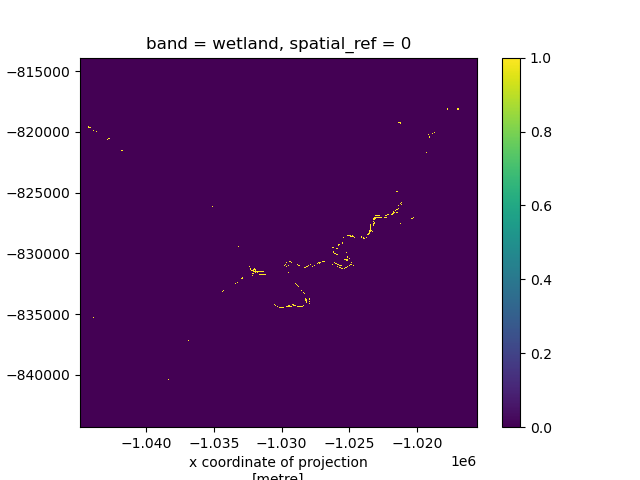

In [24]:
%matplotlib widget
binary_landcover.sel(band='wetland').plot()

# Accumulate the Upstream Area

## Make Upstream Basin Flow Accumulation Cell (FAC) Rasters

### w/ PySheds

In [25]:
%%time
fac_pysheds = terrainengine.pysheds_engine.fac_from_fdr(
    d8_fdr=us_fdr_esri,
    upstream_pour_points=None,
    )
print(f'PySheds FAC nodata value: {fac_pysheds.rio.nodata}')

PySheds FAC nodata value: nan
CPU times: total: 188 ms
Wall time: 247 ms


In [26]:
print(fac_pysheds.dtype)
fac_pysheds

float64


<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              255.0
    scale_factor:            1.0
    add_offset:              0.0

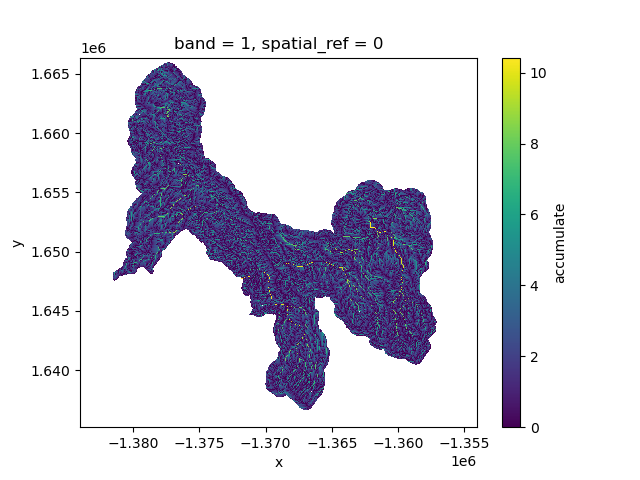

In [27]:
%matplotlib widget
np.log(fac_pysheds).plot()

### w/ TauDEM

In [28]:
%%time
fac_taudem = terrainengine.taudem_engine.fac_from_fdr(
    d8_fdr=us_fdr_taudem,
    upstream_pour_points=None,
    )
print(f'PySheds FAC nodata value: {fac_taudem.rio.nodata}')

C:\Users\xrnogueira\Documents\FCPGtools\examples\fac_tempaoca3fi_.tif


AttributeError: 'NoneType' object has no attribute 'astype'

In [29]:
print(fac_taudem.dtype)
fac_taudem

NameError: name 'fac_taudem' is not defined

In [ ]:
%matplotlib widget
np.log(fac_taudem).plot()

## Make Daymet parameter accumulation grid

## Make landcover accumulation raster

In [ ]:
%%time
landcover_accum = terrainengine.pysheds_engine.parameter_accumulate( 
    d8_fdr=us_fdr_esri,
    parameter_raster=binary_landcover,
    )
landcover_accum

In [ ]:
%matplotlib widget
np.log(landcover_accum[2]).plot()

In [ ]:
%matplotlib widget
test = landcover_accum[9]
test

In [ ]:
%matplotlib widget
np.log(replace_value(test)).plot()

In [ ]:
%matplotlib widget
aligned_daymet.plot()

In [ ]:
%matplotlib widget
landcover_accum[1].plot()

# Demonstration of Multiple Pour Points

## Find Pour Point to Downstream Area

# Create Up- and Down-stream Daymet and Land Cover FCPGs

## FCPG Upstream Daymet and Land Cover

## Cascade to Downstream Area